In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp
import numpy as np

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.fb import ForwardBackwardAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

In [2]:
def random_exploration(env, num_episodes=100, num_steps=200, layout_type: int = 1):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []

    for _ in range(num_episodes):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        while i < num_steps:
            i+=1
            cur_observations.append(np.array(state, dtype=np.float32))
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    dataset['layout_type'] = np.repeat(np.array(layout_type), repeats=(dataset['actions'].shape[0], ))
    return coverage_map, dataset

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

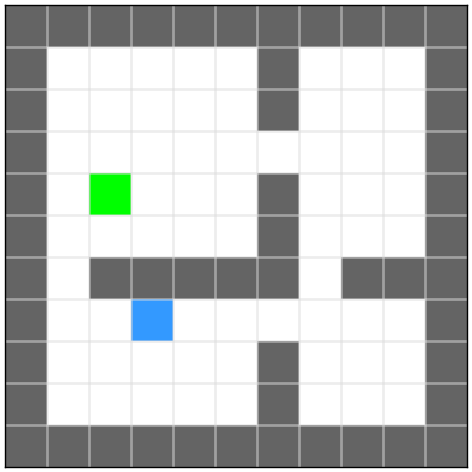

In [3]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
fourrooms_env.reset()
fourrooms_env.render(return_img=False)

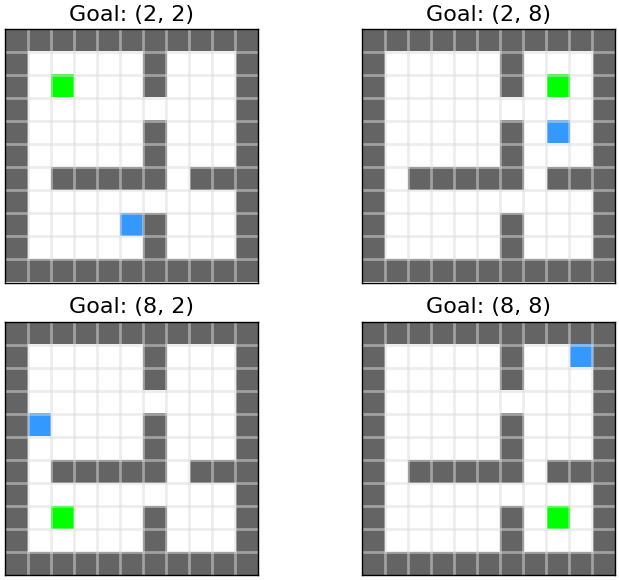

In [4]:
fourrooms_env.visualize_goals()

In [5]:
from utils.datasets import Dataset

NUM_LAYOUTS = 5
train_layout_data = []
for i in tqdm(range(NUM_LAYOUTS)):
    fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
    coverage_map_random, dataset_random = random_exploration(fourrooms_env, layout_type=i)
    train_layout_data.append(dataset_random)
    
# visualize_coverage_map(coverage_map_random, name='Random')
# # np.save("../aux_data/gridworld_data", arr=jax.device_get(whole_data))
# whole_dataset = Dataset.create(**jax.device_get(dataset_random))

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
import functools

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=discrete_transformer.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 1337,
│   'run_group': 'dynamics_aware_fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 200000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_aware_fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'n_blocks': 4,
│   │   'n_heads': 5,
│   │   'h_dim': 150,
│   │   'context_len': 1024,
│   │   'f_hidden_dims': [512, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True
│   },
│   'env': {'env_name': 'gridworld', 'discrete': True},
│   'tags': ['fb', 'discrete']
}

In [11]:
test = gc_whole_dataset.sample(10, layout_type=1, context_length=20)[1]

In [8]:
from utils.networks import DynamicsTransformer

trans_def = DynamicsTransformer(
    n_blocks=fb_config['agent']['n_blocks'],
    n_heads=fb_config['agent']['n_heads'],
    context_len=1024,
    h_dim=fb_config['agent']['h_dim'],
    drop_p=0.1
)

In [15]:
params = trans_def.init(GLOBAL_KEY, states=jnp.zeros((1, 1, 2)), actions=jnp.zeros((1, 1, 1)),
                        latent_z=jnp.zeros((1, 1, fb_config['agent']['z_dim'], )))

In [20]:
trans_def.apply(params, test['observations'], test['actions'], jnp.ones((10, 1, fb_config['agent']['z_dim']))).shape

(10, 20, 150)

In [ ]:
# fb_agent = ForwardBackwardAgent.create(
#     0,
#     example_batch['observations'],
#     np.full_like(example_batch['actions'], fourrooms_env.action_space.n - 1),
#     config=fb_config['agent']
# )

In [7]:
# with jax.disable_jit():
for _ in tqdm(range(10_000)):
    fb_agent, info = fb_agent.update(gc_whole_dataset.sample(1024))
info

  0%|          | 0/10000 [00:00<?, ?it/s]

{'fb/correct_b_ort': Array(68, dtype=int32),
 'fb/fb_diag_loss': Array(-548.182, dtype=float32),
 'fb/fb_loss': Array(-443.56354, dtype=float32),
 'fb/fb_offdiag_loss': Array(70.44615, dtype=float32),
 'fb/mean_diag': Array(149.89575, dtype=float32),
 'fb/mean_off_diag': Array(2.3100576, dtype=float32),
 'fb/z_norm': Array(12.24745, dtype=float32),
 'grad/max': Array(223.2168, dtype=float32),
 'grad/mean': Array(-0.01291231, dtype=float32),
 'grad/min': Array(-190.84465, dtype=float32),
 'grad/norm': Array(2736.6023, dtype=float32)}

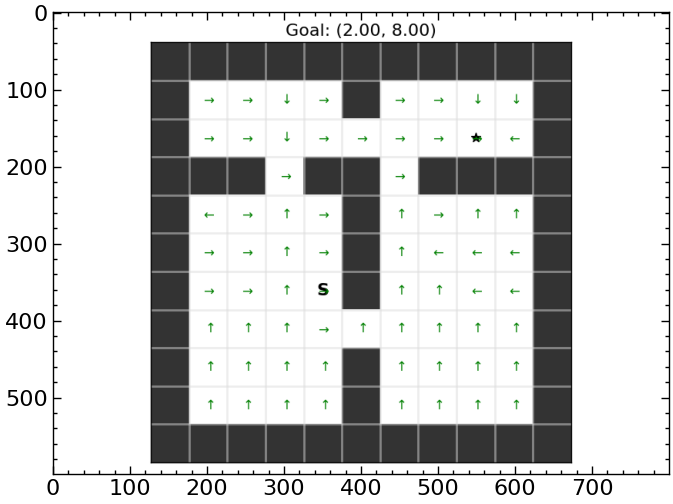

In [16]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

# fourrooms_env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
# fourrooms_env.reset()

observation, info = fourrooms_env.setup_goals(seed=None, task_num=2)
goal = info.get("goal_pos", None)
latent_z = fb_agent.infer_z(goal)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
N, M = fourrooms_env.maze.size
pred_policy_img = policy_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=1.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

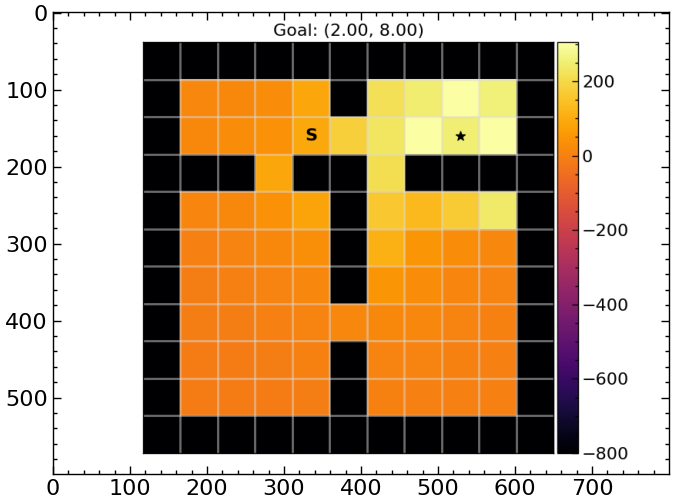

In [15]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

observation, info = fourrooms_env.setup_goals(seed=None, task_num=2)
goal = info.get("goal_pos", None)
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = fourrooms_env.maze.size
pred_value_img = value_image_fourrooms(fourrooms_env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
plt.imshow(pred_value_img)